In [12]:
import torch
import torchvision
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
%matplotlib inline

from ripser import lower_star_img
from ripser import Rips

import persim
import diagram2vec

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

import gudhi as gd
from gudhi.wasserstein import wasserstein_distance as dist_w

from IPython.display import clear_output
import pandas as pd
from PIL import Image
import importlib

from transforms import *


In [13]:
def process_by_direction_images(dataset, alpha, count=3):
    idxes = np.random.randint(0, len(dataset), count)
    images = []
    for idx in idxes:
        images.append(dataset[idx][0])
    processed = [process_by_direction(image, alpha) for image in images]
    fig, axs = plt.subplots(2, count, figsize=(10, 5))
    for i in range(count):
        axs[0, i].imshow(images[i], cmap='gray')
        axs[1, i].imshow(processed[i], cmap='bwr')
    plt.show()

In [14]:
def cedt(img, window_size):
    img /= img.max()
    img = maximum_filter(img, size=window_size)
    positive_edt = torch.Tensor(distance_transform_edt(img > 0.5))
    negative_edt = torch.Tensor(distance_transform_edt(img <= 0.5))
    cedt = positive_edt - negative_edt
    return cedt

def process_cedt_thickening_images(dataset, thickening, count=3):
    idxes = np.random.randint(0, len(dataset), count)
    images = []
    for idx in idxes:
        images.append(dataset[idx][0])
    processed = [cedt(image, thickening) for image in images]
    fig, axs = plt.subplots(2, count, figsize=(10, 5))
    for i in range(count):
        axs[0, i].imshow(images[i], cmap='gray')
        axs[1, i].imshow(processed[i], cmap='bwr', vmin=-math.sqrt(2) * processed[i].shape[0], vmax=math.sqrt(2) * processed[i].shape[0])
    plt.show()



In [15]:
def process_conv_images(dataset, kernel_size, count=3):
    idxes = np.random.randint(0, len(dataset), count)
    images = []
    for idx in idxes:
        images.append(dataset[idx][0])
    conv = nn.Conv2d(1, 1, kernel_size=kernel_size)
    # print(conv(images[0][None, :, :]).shape)
    processed = [conv(torch.tensor(image[None, :, :]).float()) for image in images]
    fig, axs = plt.subplots(2, count, figsize=(10, 5))
    for i in range(count):
        axs[0, i].imshow(images[i], cmap='gray')
        axs[1, i].imshow(processed[i].squeeze().detach().numpy(), cmap='bwr')
    plt.show()

## MNIST

### Directional

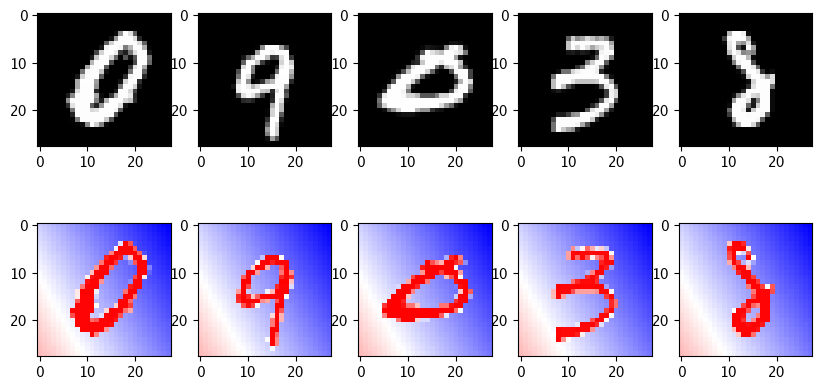

In [23]:
mnist_train = torch.load('../data/mnist/images_train.pt')
process_by_direction_images(mnist_train, 2 * math.pi / 3, 5)

### CEDT

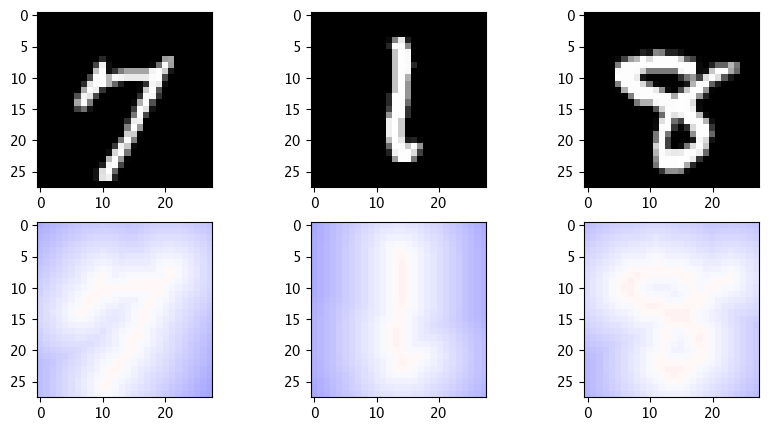

In [24]:
process_cedt_thickening_images(mnist_train, 0)

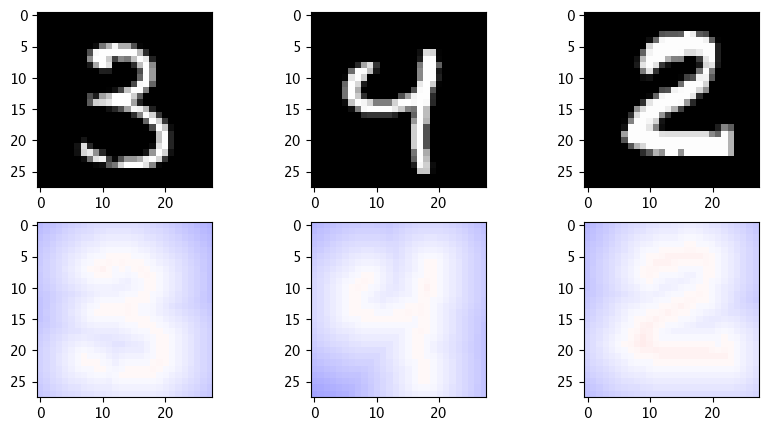

In [18]:
process_cedt_thickening_images(mnist_train, 1)

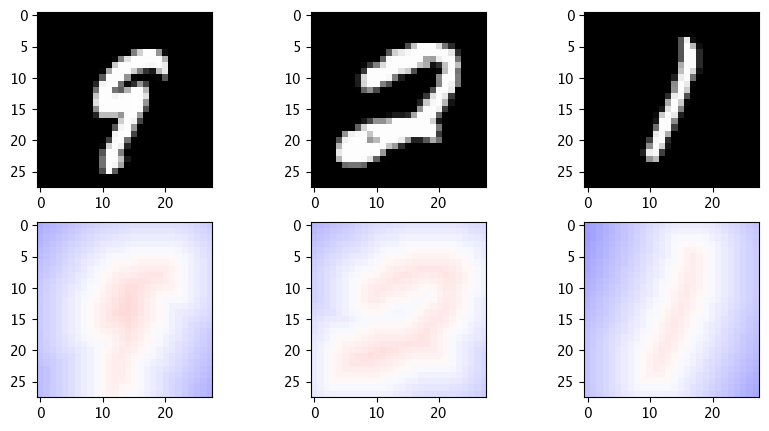

In [19]:
process_cedt_thickening_images(mnist_train, 4)

### Conv

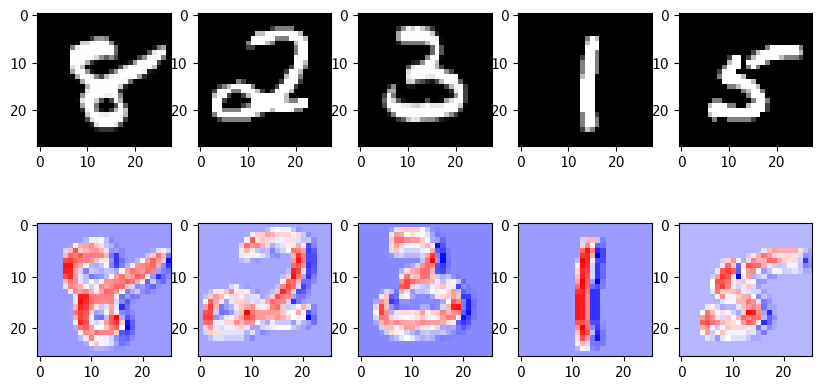

In [20]:
process_conv_images(mnist_train, 3, 5)


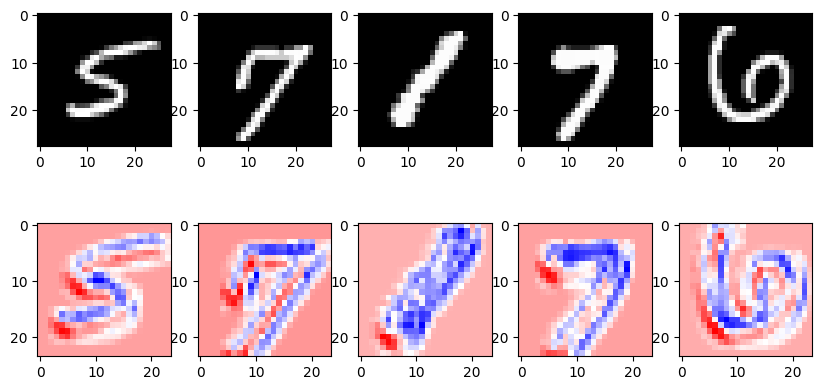

In [296]:
process_conv_images(mnist_train, 5, 5)

## CIFAR10

### Directional



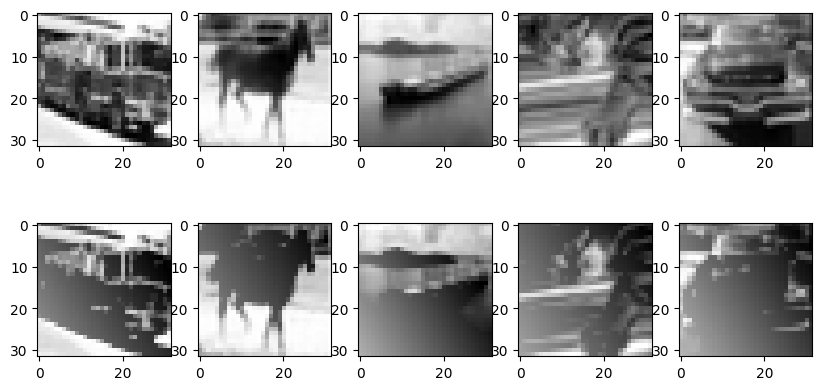

In [250]:
mnist_train = torch.load('../data/cifar10/images_train.pt')
process_by_direction_images(mnist_train, 2 * math.pi / 3, 5)

### CEDT

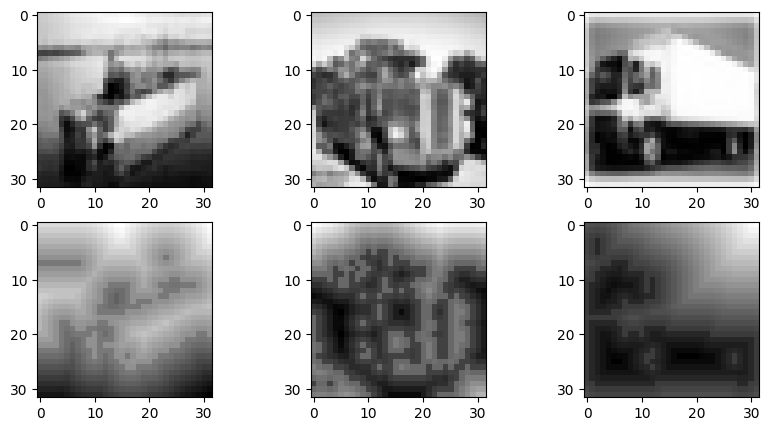

In [251]:
process_cedt_thickening_images(mnist_train, 0)

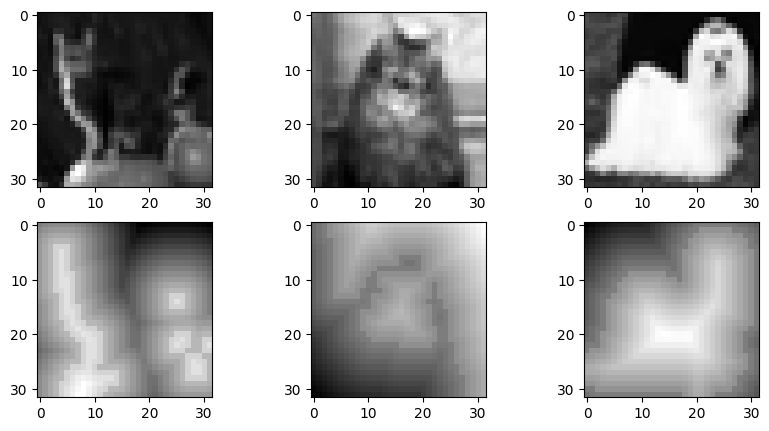

In [252]:
process_cedt_thickening_images(mnist_train, 3)

### Conv

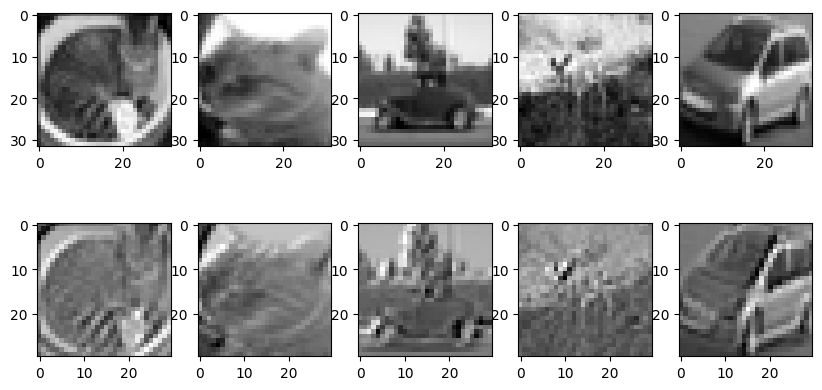

In [253]:
process_conv_images(mnist_train, 3, 5)

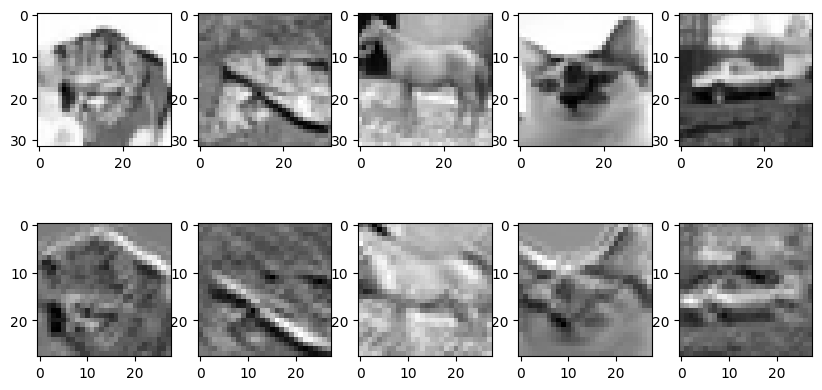

In [254]:
process_conv_images(mnist_train, 5, 5)

## Porus

### MNIST

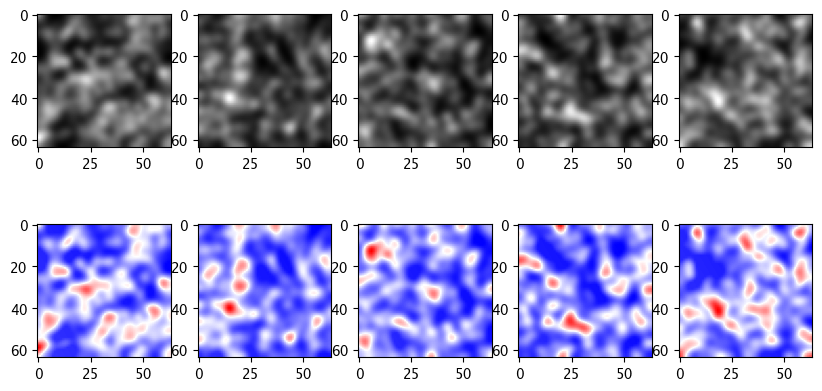

In [25]:
porus_train = torch.load('../data/porus/images_train.pt')
process_by_direction_images(porus_train, 2 * math.pi / 3, 5)

### CEDT

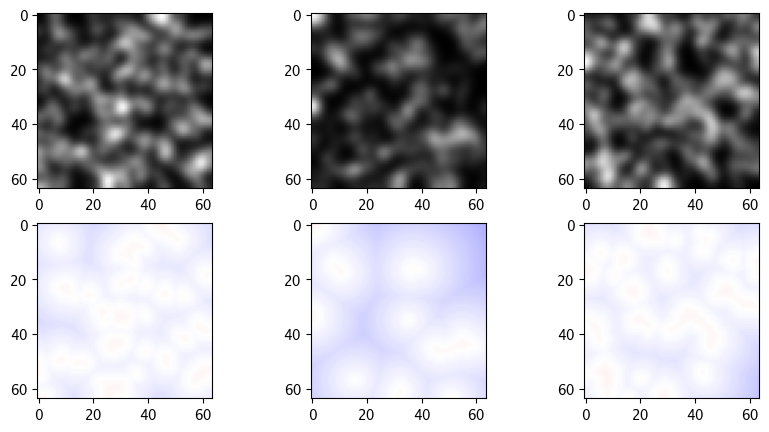

In [13]:
process_cedt_thickening_images(porus_train, 0)

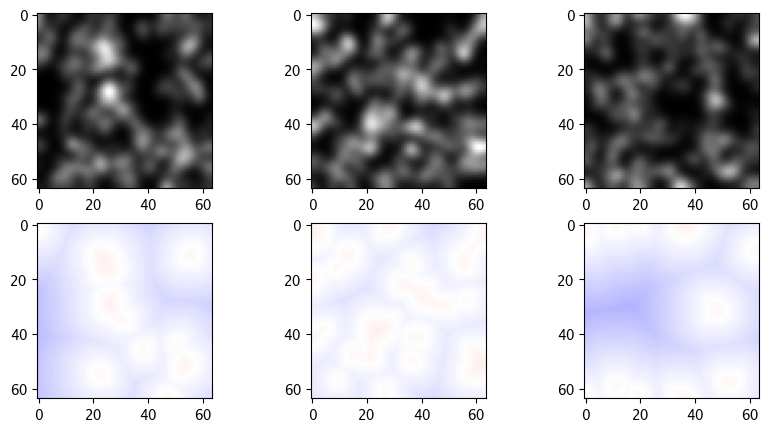

In [14]:
process_cedt_thickening_images(porus_train, 3)

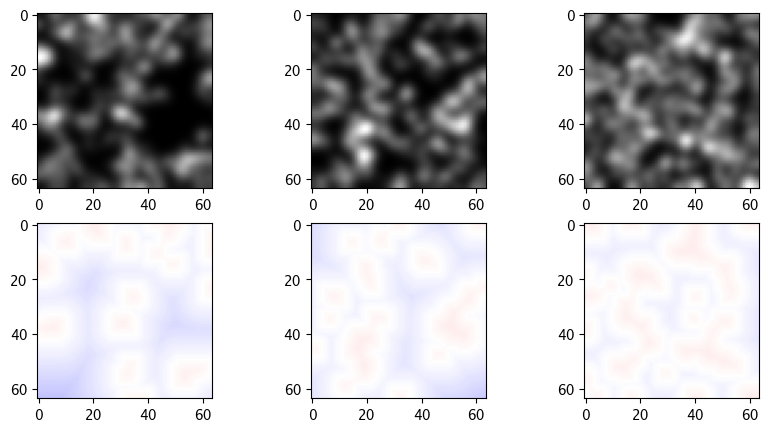

In [15]:
process_cedt_thickening_images(porus_train, 5)

### Conv

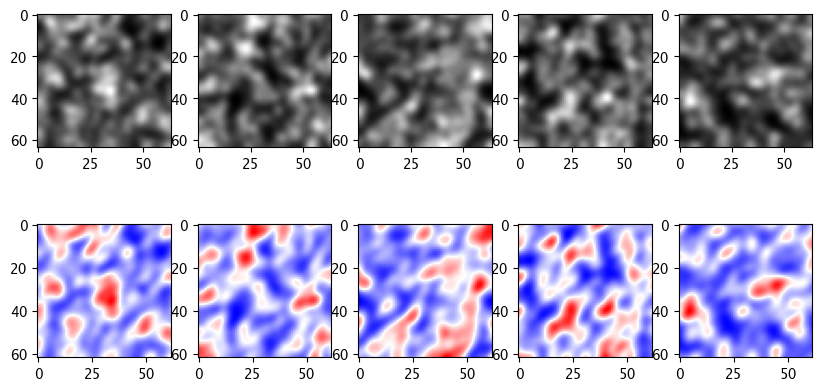

In [26]:
process_conv_images(porus_train, 3, 5)

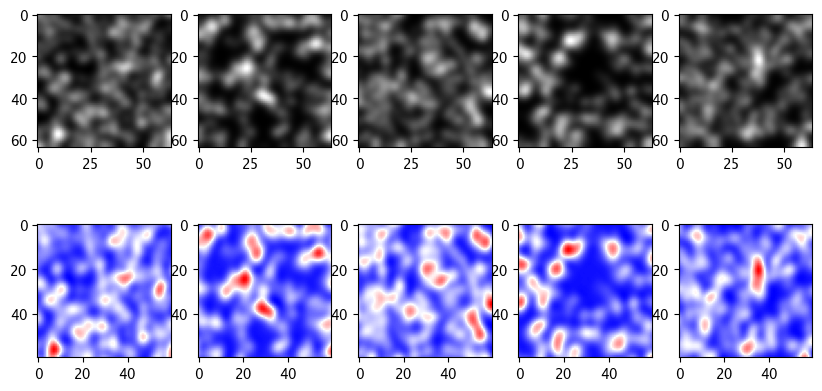

In [17]:
process_conv_images(porus_train, 5, 5)

### Chinese MNIST

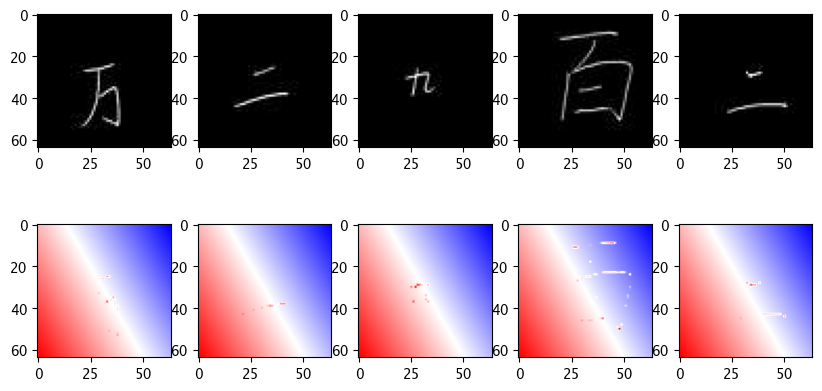

In [18]:
chinese_train = torch.load('../data/chinese-mnist/images_train.pt')
process_by_direction_images(chinese_train, 2 * math.pi / 3, 5)

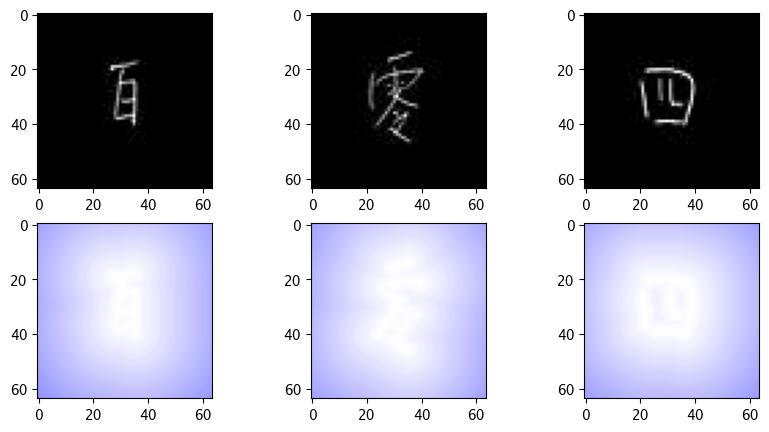

In [19]:
process_cedt_thickening_images(chinese_train, 0)

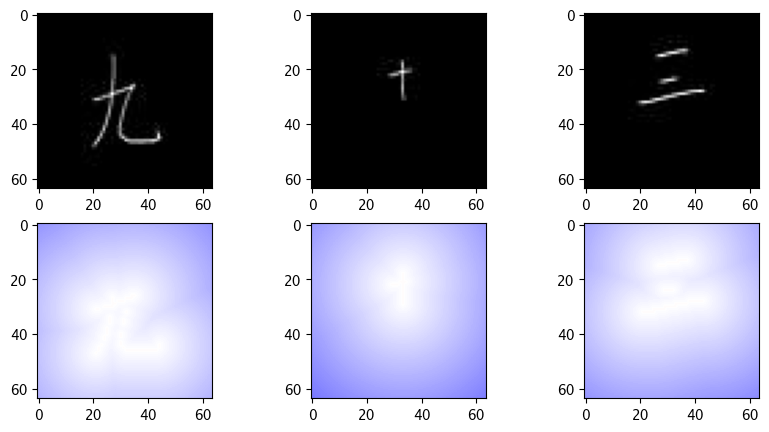

In [20]:
process_cedt_thickening_images(chinese_train, 0)

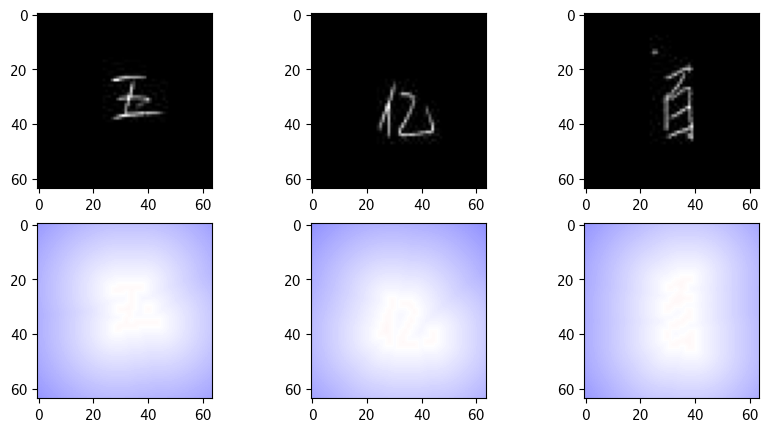

In [21]:
process_cedt_thickening_images(chinese_train, 3)

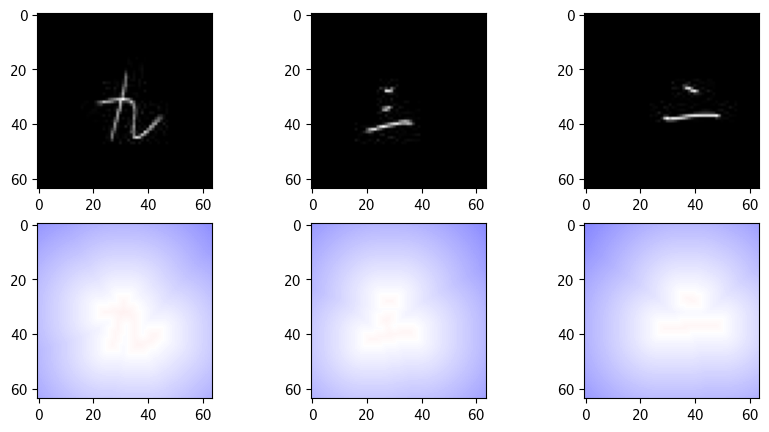

In [22]:
process_cedt_thickening_images(chinese_train, 5)

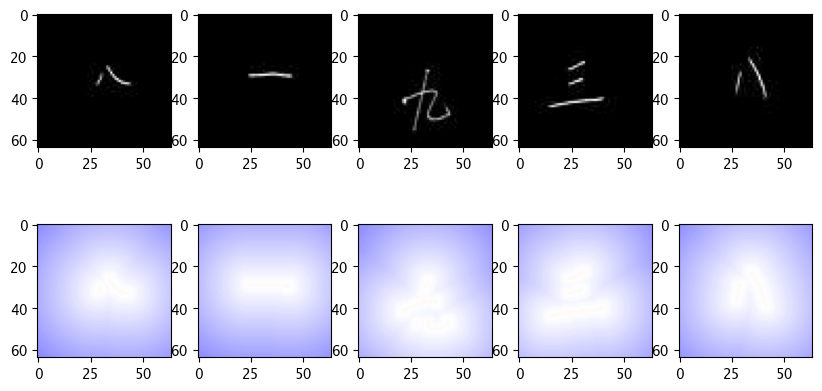

In [24]:
process_cedt_thickening_images(chinese_train, 3, 5)

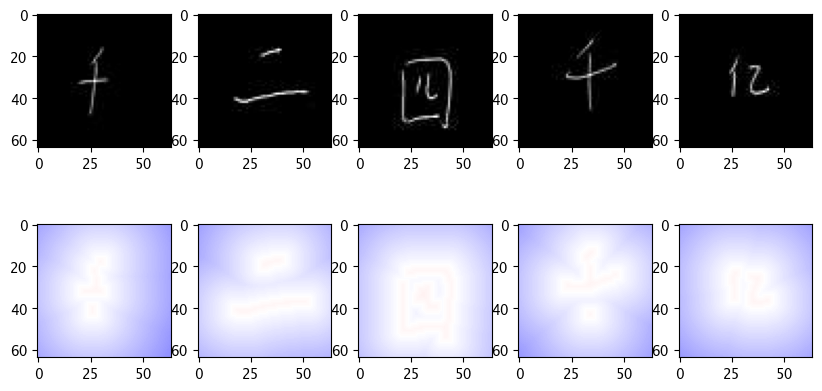

In [25]:
process_cedt_thickening_images(chinese_train, 5, 5)

## Trash

In [297]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from pytorch_lightning import LightningModule
import transforms


class Transformer(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out, seq_size=1024, nhead=2, num_layers=2, dim_feedforward=16):
        super(Transformer, self).__init__()
        self.embeddings = nn.Linear(n_in, n_hidden)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=n_hidden, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(seq_size, n_out)

    def forward(self, X):
        X = self.embeddings(X)
        X = self.transformer(X)
        X = X.mean(dim=-1)
        X = self.classifier(X)
        X = X.softmax(dim=-1)
        return X


In [310]:
class DirectionalFilter(nn.Module):
    def __init__(self, n_in, n_hidden, n_out, nhead, num_layers, dim_feedforward):
        super().__init__()


class PHT(nn.Module):
    def __init__(self, parameter_shape=None):
        super().__init__()

        
    
    def forward(self, x, parameters=None): # x.shape = [batch_size, channels, h, w] -> [batch_size, ...] | parameters.shape = [channel, parameter_shape]
        ...


class Model(nn.Module):
    def __init__(self, filter, n_in, n_hidden, n_out, nhead, num_layers, dim_feedforward):
        super().__init__()
        
        # Image filter

        self.conv_filter = nn.Conv2d(1, 3, kernel_size=3)
        # self.directional_filter = DirectionalFilter()

        self.conv_filter.parameters

        # PHT

        self.pht = PHT(self.conv_filter.weight)


        # Transformer

        self.embeddings = nn.Linear(n_in, n_hidden)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=n_hidden, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_layers)
        
        # Classifier
        
        self.classifier = nn.Linear(n_hidden, n_out)
    
    def forward(self, x, ):
        x = self.conv_filter(x)
        # x = self.directional_filter(x)
        d = self.pht(x)
        d = self.embeddings(d)
        d = self.transformer(d)
        classes = self.classifier(d)
        return classes

# class ConvTransform()

# 

In [320]:
# TODO: 

x = torch.randn(32, 228, 4)

n_in = 4
n_hidden = 16
n_out = 10
embeddings = nn.Linear(n_in, n_hidden)
x = embeddings(x)
print(x.shape)

nhead = 2
encoder_layer = nn.TransformerEncoderLayer(d_model=n_hidden, nhead=nhead, batch_first=True)
transformer = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=2)
x = transformer(x)
x = x.mean(dim=1)

print(x.shape)


classifier = nn.Linear(n_hidden, n_out)
x = classifier(x)

print(x.shape)

torch.Size([32, 228, 16])
torch.Size([32, 16])
torch.Size([32, 10])


In [329]:
conv_filter = nn.Conv2d(1, 2, kernel_size=3)
conv_filter.weight[0].shape

torch.Size([1, 3, 3])

In [7]:
data = torch.load('../data/porus/images_test.pt')

In [8]:
zero_ids = []
one_ids = []
for i in range(len(data)):
    if data[i][1] == 0:
        zero_ids.append(i)
    elif data[i][1] == 1:
        one_ids.append(i)

In [10]:
print(zero_ids[:10])
print(one_ids[:10])

[1, 2, 3, 7, 9, 10, 11, 15, 18, 19]
[0, 4, 5, 6, 8, 12, 13, 14, 16, 17]


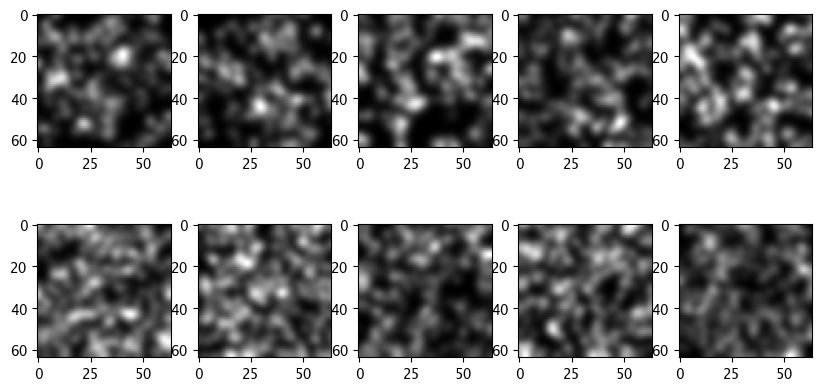

In [11]:
# 2 x 5 plt figure with 5 images of each class

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    axs[0, i].imshow(data[zero_ids[i]][0], cmap='gray')
    axs[1, i].imshow(data[one_ids[i]][0], cmap='gray')
plt.show()
